In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
today = datetime.date.today().strftime("%d-%m-%Y")
# today = '15-02-2022'
data_dir_path = f'data/World/{today}'
if not os.path.exists(f'{data_dir_path}'):
    os.mkdir(f'{data_dir_path}')

In [3]:
data = pd.read_csv('./data/Data/Output_5.csv', encoding='latin-1', skiprows=3)
countries = {
    'Albania': 'AL',
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'EL',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Montenegro': 'ME',
    'Netherlands': 'NL',
    'Norway': 'NO',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Spain': 'ES',
    'Sweden': 'SE',
    'Switzerland': 'CH',
    'Turkey': 'TR',
    'United Kingdom': 'UK',
}

for country in countries.keys():
    fixed_deaths = pd.DataFrame(columns=['Date', 'location', 'location_name', 'Age group', 'Deaths'])
    fixed_cases = pd.DataFrame(columns=['Date', 'location', 'location_name', 'Age group', 'Cases'])
    
    country_data = data[data['Country'] == country]
    country_data = country_data[country_data['Region'] == 'All']
    country_data = country_data[country_data['Date'].str[-4:-1] == '202']
    country_data['Date'] = pd.to_datetime(country_data['Date'], dayfirst=True)
    
    country_data = country_data[country_data['Sex'] == 'b']
    
    for age_group in country_data['Age'].unique():
        deaths_age_group = country_data[country_data['Age'] == age_group].groupby('Date')['Deaths'].sum().reset_index()
        cases_age_group = country_data[country_data['Age'] == age_group].groupby('Date')['Cases'].sum().reset_index()

        fixed_deaths_age_group = deaths_age_group['Deaths']
        
        if country == 'Netherlands':
            first_nonzero_index = fixed_deaths_age_group[fixed_deaths_age_group>0].index[0]
            fixed_deaths_age_group[first_nonzero_index:][fixed_deaths_age_group<=0]=np.nan
            fixed_deaths_age_group=fixed_deaths_age_group.dropna()
            z = pd.Series(fixed_deaths_age_group.to_numpy()[1:] - fixed_deaths_age_group.to_numpy()[:-1], index=fixed_deaths_age_group.index[:-1])
            fixed_deaths_age_group[:-1][z<0]=np.nan
            fixed_deaths_age_group.index=deaths_age_group['Date'][fixed_deaths_age_group.index]
        
        else:
            fixed_deaths_age_group[fixed_deaths_age_group <= 0]=np.nan
            fixed_deaths_age_group = fixed_deaths_age_group.dropna()
            fixed_deaths_age_group = np.pad(fixed_deaths_age_group, (len(deaths_age_group) - len(fixed_deaths_age_group), 0), 'constant', constant_values=(0,0))
            z = fixed_deaths_age_group[1:] - fixed_deaths_age_group[:-1]
            fixed_deaths_age_group[:-1][z<0]=np.nan
            fixed_deaths_age_group = pd.Series(fixed_deaths_age_group)
            fixed_deaths_age_group.index = deaths_age_group['Date']
            
        fixed_deaths_age_group = fixed_deaths_age_group.resample('D').mean()
        fixed_deaths_age_group = fixed_deaths_age_group.interpolate()
        
        fixed_cases_age_group = cases_age_group['Cases']
        if country == 'Netherlands':
            # find first non zero:
            first_nonzero_index = fixed_cases_age_group[fixed_cases_age_group>0].index[0]
            fixed_cases_age_group[first_nonzero_index:][fixed_cases_age_group<=0]=np.nan
            fixed_cases_age_group=fixed_cases_age_group.dropna()
            z = pd.Series(fixed_cases_age_group.to_numpy()[1:] - fixed_cases_age_group.to_numpy()[:-1], index=fixed_cases_age_group.index[:-1])
            fixed_cases_age_group[:-1][z<0]=np.nan
            fixed_cases_age_group.index=cases_age_group['Date'][fixed_cases_age_group.index]       

        else:
            
            fixed_cases_age_group[fixed_cases_age_group <= 0]=np.nan
            fixed_cases_age_group = fixed_cases_age_group.dropna()
            fixed_cases_age_group = np.pad(fixed_cases_age_group, (len(cases_age_group) - len(fixed_cases_age_group), 0), 'constant', constant_values=(0,0))
            z = fixed_cases_age_group[1:] - fixed_cases_age_group[:-1]
            fixed_cases_age_group[:-1][z<0]=np.nan
            fixed_cases_age_group = pd.Series(fixed_cases_age_group)
            fixed_cases_age_group.index = cases_age_group['Date']
        fixed_cases_age_group = fixed_cases_age_group.resample('D').mean()
        fixed_cases_age_group = fixed_cases_age_group.interpolate()

        removed_negative_deaths = np.insert(np.maximum(0, (fixed_deaths_age_group.values[1:] - fixed_deaths_age_group.values[:-1])), 0, 0)
        fixed_deaths_age_group = pd.DataFrame(fixed_deaths_age_group)
        fixed_deaths_age_group['Deaths'] = removed_negative_deaths
        fixed_deaths = fixed_deaths.append(fixed_deaths_age_group.reset_index())
        fixed_deaths['location'] = fixed_deaths['location'].fillna(country)
        fixed_deaths['location_name'] = fixed_deaths['location_name'].fillna(countries[country])
        fixed_deaths['Age group'] = fixed_deaths['Age group'].fillna(f'{age_group:02d}-{age_group + 4:02d}')
        
        removed_negative_cases = np.insert(np.maximum(0, (fixed_cases_age_group.values[1:] - fixed_cases_age_group.values[:-1])), 0, 0)
        fixed_cases_age_group = pd.DataFrame(fixed_cases_age_group)
        fixed_cases_age_group['Cases'] = removed_negative_cases
        fixed_cases = fixed_cases.append(fixed_cases_age_group.reset_index())
        fixed_cases['location'] = fixed_cases['location'].fillna(country)
        fixed_cases['location_name'] = fixed_cases['location_name'].fillna(countries[country])
        fixed_cases['Age group'] = fixed_cases['Age group'].fillna(f'{age_group:02d}-{age_group + 4:02d}')
        
    if not os.path.exists(f'{data_dir_path}/{country}'):
        os.mkdir(f'{data_dir_path}/{country}')
        
    fixed_cases = fixed_cases.rename(columns={'Date': 'date', 'Cases': 'value'})
    fixed_cases = fixed_cases.fillna(0)
    fixed_cases = fixed_cases.append(fixed_cases[fixed_cases['Age group'].isin(['85-89', '90-94', '95-99', '100-104'])].groupby(['date', 'location', 'location_name']).sum().reset_index()).fillna('85+')
    fixed_cases = fixed_cases[~fixed_cases['Age group'].isin(['85-89', '90-94', '95-99', '100-104'])].sort_values('date').reset_index(drop=True)
    fixed_cases.to_csv(f'{data_dir_path}/{country}/covid_cases.csv')
    
    fixed_deaths = fixed_deaths.rename(columns={'Date': 'date', 'Deaths': 'value'})
    fixed_deaths = fixed_deaths.fillna(0)
    fixed_deaths = fixed_deaths.append(fixed_deaths[fixed_deaths['Age group'].isin(['85-89', '90-94', '95-99', '100-104'])].groupby(['date', 'location', 'location_name']).sum().reset_index()).fillna('85+')
    fixed_deaths = fixed_deaths[~fixed_deaths['Age group'].isin(['85-89', '90-94', '95-99', '100-104'])].sort_values('date').reset_index(drop=True)
    fixed_deaths.to_csv(f'{data_dir_path}/{country}/covid_deaths.csv')
    
    # fig, axs = plt.subplots(1, 2, figsize=(30,10))
    # fixed_deaths.plot(ax=axs[0], x='date', y='value', label='deaths')
    # fixed_cases.plot(ax=axs[1], x='date', y='value', label='cases')
    # plt.savefig(f'./data/Data/Data comparation/{country}.png')
    # plt.close('all')
print('Covid files prepared')

Covid files prepared


In [4]:
read = open('data/Data/old_population.csv', 'r', encoding='utf-8')
reader = csv.reader(read)
countries = {}
for index, row in enumerate(reader):
    if index in [0]:
        continue
    short, country = row[6].split(':')
    if len(short) == 2 and country not in countries.keys():
        if short in ['FX', 'XK']:
            continue
        if short == 'DE':
            countries['Germany'] = short
        else:
            countries[country] = short
with open(f'{data_dir_path}/eurostat_countries.json', 'w') as file:
    json.dump(countries, file, indent=4)

In [5]:
file_name = 'old_population.csv'
with ExitStack() as stack:
    writer_dict = {}
    for country in countries.keys():
        if not os.path.exists(f'{data_dir_path}/{country}'):
            os.mkdir(f'{data_dir_path}/{country}')
        file_list = stack.enter_context(open(f'{data_dir_path}/{country}/{file_name}', 'w'))
        writer_dict[countries[country]] = csv.writer(file_list, delimiter=',')
        writer_dict[countries[country]].writerow(['Year', 'Region', 'Age group', 'Sex', 'Value'])
    read = stack.enter_context(open('data/Data/old_population.csv', 'r', encoding='utf-8'))
    reader = csv.reader(read)
    for index, row in enumerate(reader):
        if index in [0]:
            continue
        if row[7] >= str(2015) and row[6][:2] in writer_dict.keys():
            writer_dict[row[6][:2]].writerow([row[7], row[6].split(':')[0], row[4].split(':')[0], row[5].split(':')[0], row[8]])
print('Population files prepared')

Population files prepared


In [6]:
file_name = 'old_deaths.csv'
with ExitStack() as stack:
    writer_dict = {}
    for country in countries.keys():
        file_list = stack.enter_context(open(f'{data_dir_path}/{country}/{file_name}', 'w'))
        writer_dict[countries[country]] = csv.writer(file_list, delimiter=',')
        writer_dict[countries[country]].writerow(['Year', 'Region', 'Age group', 'Sex', 'Value'])
    read = stack.enter_context(open('data/Data/old_deaths.csv', 'r', encoding='utf-8'))
    reader = csv.reader(read)
    for index, row in enumerate(reader):
        if index in [0]:
            continue
        if row[7][:4] >= str(2015) and row[6][:2] in writer_dict.keys():
            writer_dict[row[6][:2]].writerow([row[7], row[6].split(':')[0], row[3].split(':')[0], row[4].split(':')[0], row[8]])
print('Deaths files prepared')

Deaths files prepared


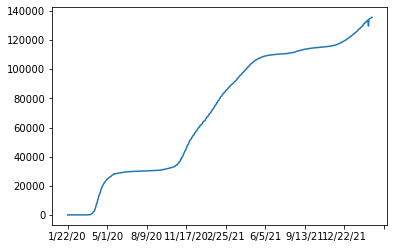

In [7]:
jhd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# jhd = jhd[jhd['Country/Region'] == 'France']
# jhd = jhd[jhd['Province/State'] == 'NaN']
jhd.iloc[131, 4:].plot()
plt.show()

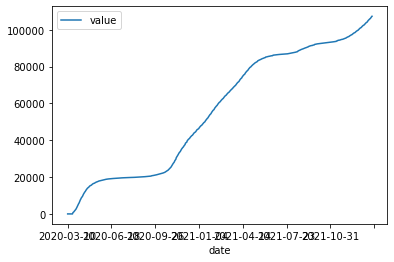

In [8]:
deaths = pd.read_csv(f'{data_dir_path}/France/covid_deaths.csv', index_col=0).reset_index(drop=True)
deaths = deaths.drop(columns=['location', 'location_name', '0']).groupby('date').sum()
deaths.cumsum().plot()
plt.show()

In [9]:
    country_data = data[data['Country'] == 'France']
    country_data = country_data[country_data['Region'] == 'All']
    country_data = country_data[country_data['Date'].str[-4:-1] == '202']
    country_data['Date'] = pd.to_datetime(country_data['Date'], dayfirst=True)
    country_data = country_data.fillna(0).drop(columns=['Country', 'Region', 'Code', 'Tests', 'AgeInt']).groupby(['Date', 'Sex']).sum().reset_index()
    country_data[country_data['Sex'] != 'b'].groupby(['Date']).sum().reset_index()

,Date,Age,Cases,Deaths
0,2020-03-10,2100,7.9,0.0
1,2020-03-11,2100,24.1,0.0
2,2020-03-12,2100,56.9,0.0
3,2020-03-13,2100,117.8,0.0
4,2020-03-14,2100,172.1,0.0
...,...,...,...,...
691,2022-01-30,2100,0.0,103554.8
692,2022-01-31,2100,0.0,103906.1
693,2022-02-01,2100,0.0,104290.0
694,2022-02-02,2100,0.0,104566.6


In [10]:
country_data[country_data['Sex'] == 'b'].groupby(['Date']).sum().reset_index()

,Date,Age,Cases,Deaths
0,2020-03-10,1050,7.9,0.0
1,2020-03-11,1050,24.0,0.0
2,2020-03-12,1050,56.9,0.0
3,2020-03-13,1050,118.1,0.0
4,2020-03-14,1050,172.3,0.0
...,...,...,...,...
691,2022-01-30,1050,0.0,103554.9
692,2022-01-31,1050,0.0,103906.2
693,2022-02-01,1050,0.0,104290.0
694,2022-02-02,1050,0.0,104566.9
